In [1]:
import cv2
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision.datasets as datasets
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')

In [3]:
#Transformation for image 
transform_ori = transforms.Compose([transforms.Resize(120),              
                                    transforms.CenterCrop(120),         
                                    transforms.RandomHorizontalFlip(),   #flipping the image horizontally
                                    transforms.ToTensor(),               #convert the image to a Tensor
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  #normalize the image

In [4]:
#Load our dataset
root_dir = 'D:/DS/Projects/my-deep-learning-projects/CNN/Image classification/Data'

# Use os.path.join to construct the full paths
train_dataset_path = os.path.join(root_dir, 'seg_train/seg_train')
test_dataset_path = os.path.join(root_dir, 'seg_test/seg_test')
# pred_dataset_path = os.path.join(root_dir, 'seg_pred/seg_pred')

# Load the datasets
train_dataset = datasets.ImageFolder(root=train_dataset_path, transform=transform_ori)
test_dataset = datasets.ImageFolder(root=test_dataset_path, transform=transform_ori)

# Check the class names (folder names)
print("Training classes:", train_dataset.classes)
print("Testing classes:", test_dataset.classes)

# Optionally, you can also check some samples to ensure it's loaded correctly
print("Number of training samples:", len(train_dataset))
print("Number of testing samples:", len(test_dataset))

Training classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Testing classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Number of training samples: 14034
Number of testing samples: 3000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


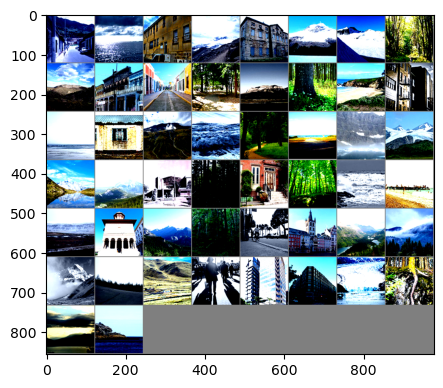

In [5]:
# Make the dataset iterable
batch_size = 50
train_load = torch.utils.data.DataLoader(dataset = train_dataset, 
                                         batch_size = batch_size,
                                         shuffle = True)      #Shuffle to create a mixed batches of 100 of cat & dog images
test_load = torch.utils.data.DataLoader(dataset = test_dataset, 
                                         batch_size = batch_size,
                                         shuffle = False)

#Show a batch of images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(5,5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# Get some random training images
dataiter = iter(train_load)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.01)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(in_features=28800, out_features=2000)  # Adjust the input features
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=2000, out_features=500)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(in_features=500, out_features=125)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc4 = nn.Linear(in_features=125, out_features=20)
        self.dropout4 = nn.Dropout(p=0.5)
        self.fc5 = nn.Linear(in_features=20, out_features=6)

        # Initialize the weights
        # self._initialize_weights()
        
    def forward(self, x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.leakyrelu(out)
        out = self.maxpool1(out)
        
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.leakyrelu(out)
        out = self.maxpool2(out)
        
        # print("Shape after cnn2 and maxpool2:", out.shape)
        # print("Shape before flattening:", out.shape) 
        
        out = out.view(out.size(0), -1)  # Dynamically adjust to batch size

        # print("Shape after flattening:", out.shape)
        
        out = self.fc1(out)
        out = self.leakyrelu(out)
        out = self.dropout1(out)
        
        out = self.fc2(out)
        out = self.leakyrelu(out)
        out = self.dropout2(out)
        
        out = self.fc3(out)
        out = self.leakyrelu(out)
        out = self.dropout3(out)
        
        out = self.fc4(out)
        out = self.leakyrelu(out)
        out = self.dropout4(out)
        
        out = self.fc5(out)
        return out

    # def _initialize_weights(self):
    #     for m in self.modules():
    #         if isinstance(m, nn.Conv2d):
    #             nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    #         elif isinstance(m, nn.BatchNorm2d):
    #             nn.init.constant_(m.weight, 1)
    #             nn.init.constant_(m.bias, 0)
    #         elif isinstance(m, nn.Linear):
    #             nn.init.normal_(m.weight, 0, 0.01)
    #             nn.init.constant_(m.bias, 0)

In [15]:
class EarlyStopping:
    def __init__(self, tolerance=10, min_delta=0):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, validation_loss):
        if self.best_loss is None:
            self.best_loss = validation_loss
        elif validation_loss < self.best_loss - self.min_delta:
            self.best_loss = validation_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.tolerance:
                self.early_stop = True


In [16]:
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()        
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
early_stopping = EarlyStopping(tolerance=10, min_delta=0.01)
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.01,)# momentum=0.9)
# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [17]:
#Training the CNN
import time

# Training parameters
num_epochs = 70

# Lists to store loss and accuracy
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

# Training loop
for epoch in range(num_epochs):
    start = time.time()
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.train()
    
    for i, (inputs, labels) in enumerate(train_load):
      
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        iter_loss += loss.item()  
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        iterations += 1
    
    train_loss.append(iter_loss / iterations)
    train_accuracy.append(100 * correct / len(train_dataset))
    
    # Testing
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.eval()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_load):
            
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            iter_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            iterations += 1
    
    test_loss.append(iter_loss / iterations)
    test_accuracy.append(100 * correct / len(test_dataset))
    # scheduler.step()

    early_stopping(test_loss[-1])
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break
        
    stop = time.time()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss[-1]:.3f}, Training Accuracy: {train_accuracy[-1]:.3f}, Testing Loss: {test_loss[-1]:.3f}, Testing Acc: {test_accuracy[-1]:.3f}, Time: {stop-start}s')


Epoch 1/70, Training Loss: 1.736, Training Accuracy: 25.980, Testing Loss: 1.357, Testing Acc: 40.433, Time: 43.80872678756714s
Epoch 2/70, Training Loss: 1.419, Training Accuracy: 40.787, Testing Loss: 1.151, Testing Acc: 54.233, Time: 43.1834237575531s
Epoch 3/70, Training Loss: 1.277, Training Accuracy: 48.147, Testing Loss: 1.049, Testing Acc: 58.433, Time: 40.13489532470703s
Epoch 4/70, Training Loss: 1.157, Training Accuracy: 54.646, Testing Loss: 0.969, Testing Acc: 63.500, Time: 40.53997850418091s
Epoch 5/70, Training Loss: 1.101, Training Accuracy: 56.926, Testing Loss: 0.953, Testing Acc: 63.300, Time: 40.13430738449097s
Epoch 6/70, Training Loss: 1.051, Training Accuracy: 59.848, Testing Loss: 0.866, Testing Acc: 62.733, Time: 40.466747760772705s
Epoch 7/70, Training Loss: 0.999, Training Accuracy: 60.980, Testing Loss: 0.853, Testing Acc: 68.967, Time: 40.69500255584717s
Epoch 8/70, Training Loss: 0.980, Training Accuracy: 61.843, Testing Loss: 0.811, Testing Acc: 66.633, T

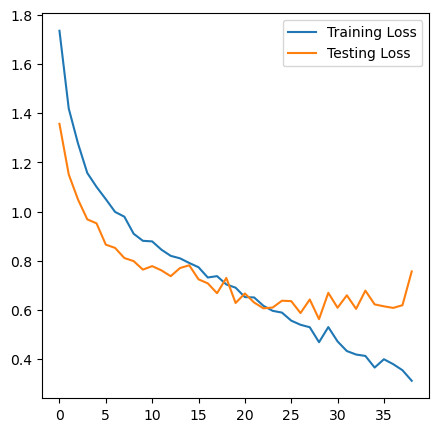

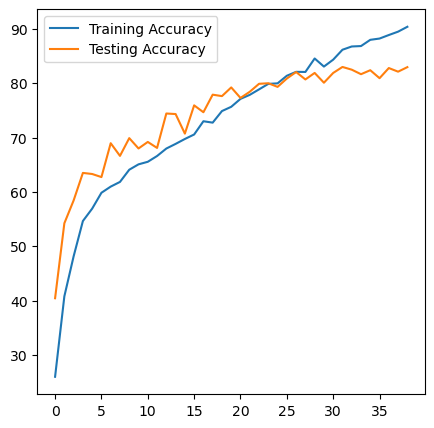

In [18]:
# Loss
f = plt.figure(figsize=(5, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

# Accuracy
f = plt.figure(figsize=(5, 5))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend()
plt.show()

#Run this if you want to save the model
torch.save(model.state_dict(),'intel_classifier.pth')

#Run this if you want to load the model
# model.load_state_dict(torch.load('CR7_GB11.pth'))

In [20]:
import torch

if torch.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available.")

CUDA is available!


In [21]:
num_gpus = torch.cuda.device_count()
print(f"Number of available GPUs: {num_gpus}")

Number of available GPUs: 1


In [22]:
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    print(f"  - Memory Allocated: {torch.cuda.memory_allocated(i) / 1024 ** 3:.2f} GB")
    print(f"  - Memory Cached: {torch.cuda.memory_reserved(i) / 1024 ** 3:.2f} GB")
    print(f"  - Total Memory: {torch.cuda.get_device_properties(i).total_memory / 1024 ** 3:.2f} GB")

GPU 0: NVIDIA GeForce GTX 1650 Ti
  - Memory Allocated: 1.34 GB
  - Memory Cached: 1.83 GB
  - Total Memory: 4.00 GB


In [23]:
root_dir = 'D:/DS/Projects/my-deep-learning-projects/CNN/Image classification/Data'
pred_dataset_path = os.path.join(root_dir, 'seg_pred/seg_pred')

# Define image transformations for prediction
prediction_transform = transforms.Compose([
    transforms.Resize(120),
    transforms.CenterCrop(120),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def predict_and_display(model, image_paths, transform, class_mapping):
    model.eval()
    with torch.no_grad():
        for image_path in image_paths:
            # Load and preprocess the image
            image = Image.open(image_path)
            image_tensor = transform(image).unsqueeze(0).to(device)

            # Perform inference
            outputs = model(image_tensor)
            _, predicted = torch.max(outputs.data, 1)
            
            # Display the output label
            predicted_label = class_mapping[predicted.item()]
            print(f'Image: {image_path}, Predicted Label: {predicted_label}')

# Paths to a few images for prediction
image_path_1 = os.path.join(pred_dataset_path, '3.jpg')
image_path_2 = os.path.join(pred_dataset_path, '5.jpg')
image_path_3 = os.path.join(pred_dataset_path, '6.jpg')
image_path_4 = os.path.join(pred_dataset_path, '11.jpg')
image_path_5 = os.path.join(pred_dataset_path, '14.jpg')
image_path_6 = os.path.join(pred_dataset_path, '22.jpg')
image_path_7 = os.path.join(pred_dataset_path, '25.jpg')
image_path_8 = os.path.join(pred_dataset_path, '28.jpg')
image_path_9 = os.path.join(pred_dataset_path, '30.jpg')
image_path_10 = os.path.join(pred_dataset_path, '38.jpg')
image_path_11= os.path.join(pred_dataset_path, '51.jpg')
image_path_12 = os.path.join(pred_dataset_path, '52.jpg')

image_paths = [image_path_1, image_path_2, image_path_3, image_path_4, image_path_5, image_path_6, image_path_7, image_path_8, image_path_9,
              image_path_10, image_path_11, image_path_12]

class_mapping = {0 : 'buildings',
  1 : 'forest',
  2 : 'glacier',
  3 : 'mountain',
  4 : 'sea',
  5 : 'street'}

# Predict and display outputs
predict_and_display(model, image_paths, prediction_transform, class_mapping)


Image: D:/DS/Projects/my-deep-learning-projects/CNN/Image classification/Data\seg_pred/seg_pred\3.jpg, Predicted Label: street
Image: D:/DS/Projects/my-deep-learning-projects/CNN/Image classification/Data\seg_pred/seg_pred\5.jpg, Predicted Label: buildings
Image: D:/DS/Projects/my-deep-learning-projects/CNN/Image classification/Data\seg_pred/seg_pred\6.jpg, Predicted Label: sea
Image: D:/DS/Projects/my-deep-learning-projects/CNN/Image classification/Data\seg_pred/seg_pred\11.jpg, Predicted Label: sea
Image: D:/DS/Projects/my-deep-learning-projects/CNN/Image classification/Data\seg_pred/seg_pred\14.jpg, Predicted Label: street
Image: D:/DS/Projects/my-deep-learning-projects/CNN/Image classification/Data\seg_pred/seg_pred\22.jpg, Predicted Label: forest
Image: D:/DS/Projects/my-deep-learning-projects/CNN/Image classification/Data\seg_pred/seg_pred\25.jpg, Predicted Label: sea
Image: D:/DS/Projects/my-deep-learning-projects/CNN/Image classification/Data\seg_pred/seg_pred\28.jpg, Predicted

In [ ]:
class_mapping = train_load.dataset.class_to_idx

In [ ]:
class_mapping

In [ ]:
root_dir = 'D:/DS/Projects/my-deep-learning-projects/CNN/Image classification/Data'
test_dataset_path = os.path.join(root_dir, 'seg_test/seg_test')

# Define image transformations for prediction
test_transform = transforms.Compose([
    transforms.Resize(120),
    transforms.CenterCrop(120),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Create a PyTorch ImageFolder dataset for the test set
test_dataset = datasets.ImageFolder(root=test_dataset_path, transform=test_transform)

# Create a data loader for the test set
batch_size = 32
test_load = torch.utils.data.DataLoader(dataset = test_dataset, 
                                         batch_size = batch_size,
                                         shuffle = False)
# Function to test the model on the test set
def test_model(model, test_load):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_load:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')

# Test the model on the test set
test_model(model, test_load)